# ** Описание **

Построить графики распределения в спам и не спам множествах следующих признаков:

1	Количество слов на странице
2	Средняя длинна слова
3	Количество слов в заголовке страниц (слова в теге <html><head><title> Some text </title>)
4	Количество слов в анкорах ссылок (<html><body><a> Some text </a>)
5	Коэффициент сжатия

Нужно посчитать статистику минимум по трем признакам и обязательно сделать для 1-го и 2-го признаков

И отправить первое решение в соревнование https://www.kaggle.com/c/antispam-information-retrieval/
На основании одного из указанных выше признаков попытаться разделить мн-во, так чтобы score в соревновании был больше 0.55

При выполнении всех этих условия в течении семинара +1 балл к ДЗ

Описание ДЗ и правил выставления за него баллов в https://www.kaggle.com/c/antispam-information-retrieval/  
Сроки ДЗ уточнить у преподователя - обычно 2 недели

In [1]:
from __future__ import division

import base64
import csv
import gzip
import zlib

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
TRACE_NUM = 1000
import logging
import importlib
importlib.reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)
        
def trace_worker(items_num, worker_id, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d in worker_id %d" % (items_num, worker_id))

### Утилиты

#### Декораторы

In [3]:
# def to_utf8(text):
#     if isinstance(text, unicode): text = text.encode('utf8')
#     return text

# def convert2unicode(f):
#     def tmp(text):
#         if not isinstance(text, unicode): text = text.decode('utf8')
#         return f(text)
#     return tmp

# def convert2lower(f):
#     def tmp(text):        
#         return f(text.lower())
#     return tmp

# #P.S. Декораторы могут усложнять отладку, так что от них вполне можно отказаться и воспользоваться copy-paste

### Извлечение текста из html

#### Извлечение текста при помощи встроенных модулей

In [4]:
from html.parser import HTMLParser
import re

###Извлечение текста из title можно вписать сюда

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()

def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    return parser.text()

#### Извлечение текста при помощи дополнительных библиотек

In [5]:
def html2text_bs(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    from bs4 import BeautifulSoup
    """
    Тут производится извлечения из html текста, который видим пользователю
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    еще одна библиотека очень хорошо извлекающая именно видимый пользователю текст,
    но она завязана на java
    """
    pass

#### Выбираем какой метод для конвертации html в текст будет основным

In [6]:
#html2text = html2text_bs
html2text = html2text_parser

#### Методы для токенизации текста

In [7]:
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint, чтобы установка pymorphy2 не была бы обязательной
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### Основная функция, которая вызывается для преобразования html в список слов

In [8]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    return tokenizer(to_text(raw_html).lower())

#### Рассчет финальных метрик

In [9]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Функция подсчета метрик
    Параметры
    predictions - ранки по документам
    threshold  - порог для метрик
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [10]:
import pymorphy2
from bs4 import BeautifulSoup

In [11]:
morph = pymorphy2.MorphAnalyzer()

21:17:17 INFO:Loading dictionaries from /home/vlad/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/pymorphy2_dicts_ru/data
21:17:17 INFO:format: 2.4, revision: 417127, updated: 2020-10-11T15:05:51.070345


In [12]:
Dict = {}

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [65]:
def calc_features(url, html_data, mark):
    words = list(html2word(html_data))
    soup = BeautifulSoup(html_data, 'html.parser')
    words_num = len(words)
    words_len_sum = 0
    digits = 0
    noun_count = 0
    useless_count = 0
    spam_words_count = 0
    for word in words:
#         if word in spam_words:
#             spam_words_count += 1
        words_len_sum += len(word)
        if any(map(str.isdigit, word)):
            digits += 1
#         p = morph.parse(word)[0]
#         if 'NOUN' in p.tag:
#             noun_count += 1
#         if 'PREP' in p.tag or 'CONJ' in p.tag or 'PRCL' in p.tag or 'INTJ' in p.tag:
#             useless_count += 1
    
    avg_word_len = words_len_sum / words_num
    
    if soup.title:
        title_words_num = len(soup.title.text.split())
    else:
        title_words_num = 0
    
    links = []
    for link in soup.findAll('a'):
        links.append(link.get('href'))
    link_nums = len(links)

    anchor_words_num = 0
    compression_level = 0
    
    return [words_num, avg_word_len,
            title_words_num, anchor_words_num,
            compression_level, digits, noun_count,
            useless_count, link_nums, spam_words_count] + list(v1.transform([html_data]).toarray()[0])

In [45]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3 на под в и
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data, 0)
print(test_features)

заголовок ololo спам 1 2 3 на под в и
[10, 2.8, 2, 0, 0, 3, 0, 0, 0, 0]


In [66]:
from multiprocessing import Process, Queue

DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features'])

WORKER_NUM = 4

def load_csv(input_file_name, calc_features_f):    
    """
    Загружаем данные и извлекаем на лету признаки
    Сам контент не сохраняется, чтобы уменьшить потребление памяти - чтобы
    можно было запускать даже на ноутбуках в классе
    """
    global LAST_HTML
    with gzip.open(input_file_name, mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data, mark)            
            yield DocItem(url_id, mark, url, features)            
                
        trace(i, 1)  
        
def load_csv_worker(input_file_name, calc_features_f, worker_id, res_queue):    
    with gzip.open(input_file_name,  mode='rt', encoding='utf8') if input_file_name.endswith('gz') else open(input_file_name, mode='rt', encoding='utf8')  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace_worker(i, worker_id)
            if i % WORKER_NUM != worker_id: continue
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            try:
                html_data = html_data.decode('utf8')
            except:
                html_data = html_data.decode('latin1')
            features = calc_features_f(url, html_data, mark)            
            res_queue.put(DocItem(url_id, mark, url, features))
                
        trace_worker(i, worker_id, 1)  
    res_queue.put(None)
        
def load_csv_multiprocess(input_file_name, calc_features_f):
    processes = []
    res_queue = Queue()    
    for i in range(WORKER_NUM):
        process = Process(target=load_csv_worker, args=(input_file_name, calc_features_f, i, res_queue))
        processes.append(process)
        process.start()
    
    complete_workers = 0
    while complete_workers != WORKER_NUM:
        item = res_queue.get()
        if item is None:
            complete_workers += 1
        else:
            yield item
        
    for process in processes: process.join()

** Обрабатываем входной файл **
<br>
Формат - поля разделенные табуляциями
<br>
0 - идентификатор документа
<br>
1 - метка класса 0 - не спам, 1 - спам
<br>
2 - урл документа
<br>
3 - документ в кодировке base64

Выходной формат - массив кортежей вида
(doc_id, is_spam, url, html_data)

In [67]:
%%time

TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv'
# TRAIN_DATA_FILE  = 'kaggle_train_data_tab.csv.gz'

train_docs = list(load_csv_multiprocess(TRAIN_DATA_FILE, calc_features))
# train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))
# ololo = load_csv(TRAIN_DATA_FILE, calc_features)

22:47:37 INFO:Complete items 00000 in worker_id 0
22:47:37 INFO:Complete items 00000 in worker_id 1
22:47:37 INFO:Complete items 00000 in worker_id 2
22:47:37 INFO:Complete items 00000 in worker_id 3
22:47:54 INFO:Complete items 01000 in worker_id 0
22:47:54 INFO:Complete items 01000 in worker_id 2
22:47:56 INFO:Complete items 01000 in worker_id 3
22:47:59 INFO:Complete items 01000 in worker_id 1
22:48:13 INFO:Complete items 02000 in worker_id 2
22:48:13 INFO:Complete items 02000 in worker_id 0
22:48:16 INFO:Complete items 02000 in worker_id 1
22:48:16 INFO:Complete items 02000 in worker_id 3
22:48:31 INFO:Complete items 03000 in worker_id 0
22:48:32 INFO:Complete items 03000 in worker_id 1
22:48:33 INFO:Complete items 03000 in worker_id 2
22:48:36 INFO:Complete items 03000 in worker_id 3
22:48:48 INFO:Complete items 04000 in worker_id 0
22:48:49 INFO:Complete items 04000 in worker_id 2
22:48:52 INFO:Complete items 04000 in worker_id 1
22:48:53 INFO:Complete items 04000 in worker_id 3


CPU times: user 1.23 s, sys: 286 ms, total: 1.52 s
Wall time: 2min 18s


In [51]:
html_texts = []

In [52]:
for doc in list(train_docs):
    html_texts.append(doc.features[10])

In [36]:
# Full_words = []
# for doc in list(train_docs):
#     for i in doc.features[10]:
#         if doc.is_spam == True:
#             Full_words.append(i)

In [39]:
from collections import Counter

In [40]:
count = Counter(Full_words)
most_occur = count.most_common(10000)
spam_words = []
for i in most_occur:
    spam_words.append(i[0])
print(spam_words)

['в', 'и', 'скачать', 'порно', 'на', 'с', 'для', 'фото', 'не', '0', 'секс', 'по', 'что', 'бесплатно', 'как', 'a', 'http', 'ru', 'видео', '1', 'знакомства', '2010', 'а', 'я', 'document', 'онлайн', 'к', '2', 'он', 'из', 'за', 'драйвер', 'проститутки', 'все', 'но', 'от', 'var', 'font', 'screen', 'его', 'о', 'это', 'com', 'то', 'игры', 'диета', 'у', 'margin', 'height', 'width', 'url', 'сайт', '3', 'драйвера', 'фамилии', 'так', 'br', 'www', 'она', 'без', 'display', 'смотреть', 'же', 'google', 'color', '4', 'if', 'г', 'border', 'important', 'top', 'при', '5', 'вы', 'или', 'только', 'padding', 'write', '6', 'ее', '10', 'где', 'голые', 'background', 'до', 'когда', 'интим', 'если', 'лет', 'b', '7', 's', '11', '12', 'd', 'было', 'text', 'src', 'бы', 'секса', 'москва', 'мы', 'left', 'эротика', 'они', 'гей', 'их', '3d', 'block', 'сайта', 'size', 'можно', 'знакомств', 'div', '2009', 'гороскоп', 'чтобы', '15', 'window', 'со', 'еще', 'меня', 'escape', 'ты', 'none', '2011', 'i', 'поиск', 'img', 'title

In [ ]:
len(train_docs)

In [137]:
train_docs

[DocItem(doc_id=-9222401963271173253, is_spam=False, url='http://lawleader.ru/docs/32/', features=[3359, 6.318547186662697, 4, 0, 0, 0, 0, 0, 59]),
 DocItem(doc_id=-9216163564171210203, is_spam=True, url='http://penhea895.narod.ru/familiya-shushmarchenko.html', features=[522, 5.241379310344827, 5, 0, 0, 0, 0, 0, 79]),
 DocItem(doc_id=-9219733223042265364, is_spam=False, url='http://www.ferio.ru/c_1-acura-legend.html', features=[1551, 4.8807221147646676, 6, 0, 0, 0, 0, 0, 138]),
 DocItem(doc_id=-9210905935710158021, is_spam=True, url='http://cursedec69.110mb.com/170skachat-gfi-mailsecurity-for-exchange-smtp-v8.1.html', features=[464, 5.252155172413793, 7, 0, 0, 0, 0, 0, 27]),
 DocItem(doc_id=-9221399504663603656, is_spam=False, url='http://alterhost.ruwww.alterhost.ruwww.user.kz.ru/', features=[956, 4.908995815899582, 4, 0, 0, 0, 0, 0, 80]),
 DocItem(doc_id=-9218561774155397294, is_spam=False, url='http://fshops.otzyv.ru/read.php?id=277', features=[1062, 4.869114877589454, 3, 0, 0, 0, 0

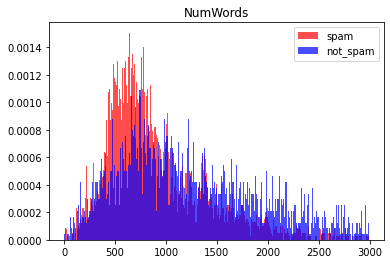

In [158]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

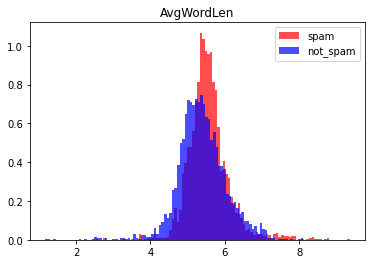

In [159]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

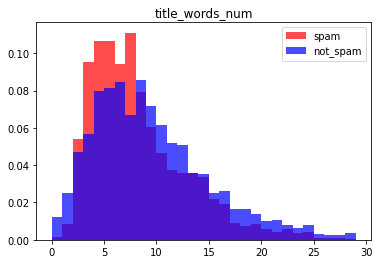

In [80]:
is_spam_data = [doc.features[2] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[2] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('title_words_num')
plt.legend()
plt.show()

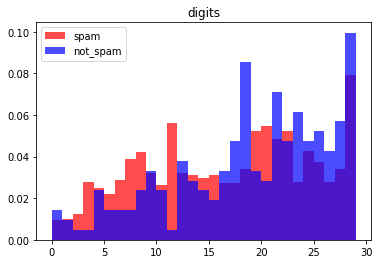

In [161]:
is_spam_data = [doc.features[5] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[5] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('digits')
plt.legend()
plt.show()

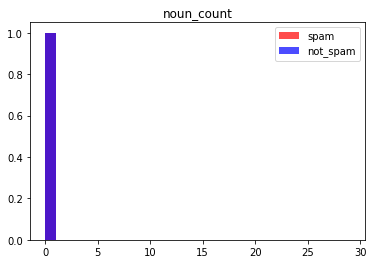

In [162]:
is_spam_data = [doc.features[6] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[6] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('link_nums')
plt.legend()
plt.show()

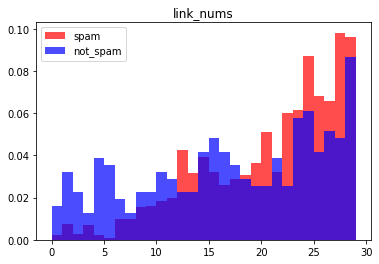

In [164]:
is_spam_data = [doc.features[8] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[8] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('link_nums')
plt.legend()
plt.show()

In [88]:
# [words_num, avg_word_len,
#             title_words_num, anchor_words_num,
#             compression_level, digits, noun_count,
#             useless_count, link_nums, spam_words_count] + list(v1.transform([html_data]).toarray()[0])

In [89]:
#Добавить графики для остальных фичей

** Классификатор: **
Нужно реализовать

In [68]:
import catboost

In [69]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier()

In [98]:
from sklearn.linear_model import LogisticRegression

In [71]:
import numpy as np

In [101]:
list(train_docs)

[DocItem(doc_id=-9222401963271173253, is_spam=False, url='http://lawleader.ru/docs/32/', features=[3359, 6.318547186662697, 4, 0, 0, 0, 0, 0, 59, 1170]),
 DocItem(doc_id=-9216163564171210203, is_spam=True, url='http://penhea895.narod.ru/familiya-shushmarchenko.html', features=[522, 5.241379310344827, 5, 0, 0, 0, 0, 0, 79, 249]),
 DocItem(doc_id=-9201586758757258004, is_spam=True, url='http://caduchandme.narod.ru/prostitutki-g-dedovska.html', features=[1095, 5.861187214611872, 12, 0, 0, 0, 0, 0, 36, 482]),
 DocItem(doc_id=-9221399504663603656, is_spam=False, url='http://alterhost.ruwww.alterhost.ruwww.user.kz.ru/', features=[956, 4.908995815899582, 4, 0, 0, 0, 0, 0, 80, 412]),
 DocItem(doc_id=-9213263092469495632, is_spam=True, url='http://ntklhjdawv5.edu.ms/5/open24-ru-znakomstva-97.html', features=[958, 5.559498956158664, 14, 0, 0, 0, 0, 0, 27, 481]),
 DocItem(doc_id=-9191036552063391799, is_spam=True, url='http://launce7fzhanel.narod.ru/ebut-zhenu-porno-roliki-onlayn.html', features=

In [72]:
X = []
y = []
for doc in train_docs:
    X.append(doc.features)
    y.append(doc.is_spam)
print(np.array(X).shape)
print(np.array(y).shape)

(7044, 210)
(7044,)


In [73]:
y = list(map(int, y))

In [74]:
from sklearn.metrics import f1_score

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
clf.fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test))

Learning rate set to 0.019064
0:	learn: 0.6708932	total: 213ms	remaining: 3m 33s
1:	learn: 0.6466867	total: 243ms	remaining: 2m 1s
2:	learn: 0.6288077	total: 288ms	remaining: 1m 35s
3:	learn: 0.6107072	total: 330ms	remaining: 1m 22s
4:	learn: 0.5900895	total: 367ms	remaining: 1m 13s
5:	learn: 0.5717200	total: 406ms	remaining: 1m 7s
6:	learn: 0.5528014	total: 454ms	remaining: 1m 4s
7:	learn: 0.5373188	total: 497ms	remaining: 1m 1s
8:	learn: 0.5219290	total: 535ms	remaining: 58.9s
9:	learn: 0.5077593	total: 572ms	remaining: 56.6s
10:	learn: 0.4941069	total: 605ms	remaining: 54.4s
11:	learn: 0.4824630	total: 637ms	remaining: 52.5s
12:	learn: 0.4706197	total: 688ms	remaining: 52.2s
13:	learn: 0.4577675	total: 727ms	remaining: 51.2s
14:	learn: 0.4430379	total: 763ms	remaining: 50.1s
15:	learn: 0.4308081	total: 797ms	remaining: 49s
16:	learn: 0.4208163	total: 831ms	remaining: 48.1s
17:	learn: 0.4115478	total: 866ms	remaining: 47.3s
18:	learn: 0.4031061	total: 912ms	remaining: 47.1s
19:	learn

160:	learn: 0.1226990	total: 7.9s	remaining: 41.2s
161:	learn: 0.1223565	total: 7.96s	remaining: 41.2s
162:	learn: 0.1218447	total: 7.99s	remaining: 41s
163:	learn: 0.1214212	total: 8.02s	remaining: 40.9s
164:	learn: 0.1209897	total: 8.08s	remaining: 40.9s
165:	learn: 0.1206496	total: 8.12s	remaining: 40.8s
166:	learn: 0.1201673	total: 8.17s	remaining: 40.8s
167:	learn: 0.1196984	total: 8.23s	remaining: 40.7s
168:	learn: 0.1192699	total: 8.28s	remaining: 40.7s
169:	learn: 0.1187791	total: 8.32s	remaining: 40.6s
170:	learn: 0.1184805	total: 8.35s	remaining: 40.5s
171:	learn: 0.1181425	total: 8.38s	remaining: 40.3s
172:	learn: 0.1178306	total: 8.42s	remaining: 40.3s
173:	learn: 0.1175414	total: 8.46s	remaining: 40.2s
174:	learn: 0.1171029	total: 8.48s	remaining: 40s
175:	learn: 0.1166288	total: 8.52s	remaining: 39.9s
176:	learn: 0.1163119	total: 8.55s	remaining: 39.8s
177:	learn: 0.1157662	total: 8.59s	remaining: 39.7s
178:	learn: 0.1154160	total: 8.62s	remaining: 39.5s
179:	learn: 0.115

321:	learn: 0.0774799	total: 14.8s	remaining: 31.1s
322:	learn: 0.0772907	total: 14.8s	remaining: 31.1s
323:	learn: 0.0770901	total: 14.9s	remaining: 31s
324:	learn: 0.0769257	total: 14.9s	remaining: 30.9s
325:	learn: 0.0766841	total: 14.9s	remaining: 30.9s
326:	learn: 0.0764797	total: 15s	remaining: 30.8s
327:	learn: 0.0762624	total: 15s	remaining: 30.7s
328:	learn: 0.0761249	total: 15s	remaining: 30.7s
329:	learn: 0.0758598	total: 15.1s	remaining: 30.6s
330:	learn: 0.0757036	total: 15.1s	remaining: 30.6s
331:	learn: 0.0755256	total: 15.2s	remaining: 30.5s
332:	learn: 0.0752849	total: 15.2s	remaining: 30.5s
333:	learn: 0.0750175	total: 15.3s	remaining: 30.4s
334:	learn: 0.0748451	total: 15.3s	remaining: 30.4s
335:	learn: 0.0746688	total: 15.3s	remaining: 30.3s
336:	learn: 0.0744243	total: 15.4s	remaining: 30.3s
337:	learn: 0.0743196	total: 15.4s	remaining: 30.2s
338:	learn: 0.0741193	total: 15.5s	remaining: 30.2s
339:	learn: 0.0739778	total: 15.5s	remaining: 30.2s
340:	learn: 0.073821

484:	learn: 0.0534046	total: 22.1s	remaining: 23.5s
485:	learn: 0.0532762	total: 22.2s	remaining: 23.4s
486:	learn: 0.0532015	total: 22.2s	remaining: 23.4s
487:	learn: 0.0530480	total: 22.2s	remaining: 23.3s
488:	learn: 0.0529408	total: 22.2s	remaining: 23.2s
489:	learn: 0.0528123	total: 22.3s	remaining: 23.2s
490:	learn: 0.0526533	total: 22.3s	remaining: 23.1s
491:	learn: 0.0524649	total: 22.3s	remaining: 23.1s
492:	learn: 0.0524191	total: 22.4s	remaining: 23s
493:	learn: 0.0523438	total: 22.4s	remaining: 23s
494:	learn: 0.0522165	total: 22.5s	remaining: 22.9s
495:	learn: 0.0521641	total: 22.5s	remaining: 22.9s
496:	learn: 0.0520655	total: 22.6s	remaining: 22.8s
497:	learn: 0.0519648	total: 22.6s	remaining: 22.8s
498:	learn: 0.0519018	total: 22.6s	remaining: 22.7s
499:	learn: 0.0518201	total: 22.7s	remaining: 22.7s
500:	learn: 0.0517184	total: 22.7s	remaining: 22.6s
501:	learn: 0.0515804	total: 22.7s	remaining: 22.6s
502:	learn: 0.0514499	total: 22.8s	remaining: 22.5s
503:	learn: 0.05

645:	learn: 0.0383288	total: 29.1s	remaining: 15.9s
646:	learn: 0.0382259	total: 29.1s	remaining: 15.9s
647:	learn: 0.0381251	total: 29.2s	remaining: 15.9s
648:	learn: 0.0380810	total: 29.2s	remaining: 15.8s
649:	learn: 0.0379968	total: 29.3s	remaining: 15.8s
650:	learn: 0.0378805	total: 29.3s	remaining: 15.7s
651:	learn: 0.0377885	total: 29.4s	remaining: 15.7s
652:	learn: 0.0377062	total: 29.4s	remaining: 15.6s
653:	learn: 0.0376815	total: 29.4s	remaining: 15.6s
654:	learn: 0.0375736	total: 29.5s	remaining: 15.5s
655:	learn: 0.0375489	total: 29.5s	remaining: 15.5s
656:	learn: 0.0374562	total: 29.6s	remaining: 15.4s
657:	learn: 0.0373541	total: 29.6s	remaining: 15.4s
658:	learn: 0.0372555	total: 29.7s	remaining: 15.3s
659:	learn: 0.0372345	total: 29.7s	remaining: 15.3s
660:	learn: 0.0371438	total: 29.7s	remaining: 15.2s
661:	learn: 0.0370742	total: 29.8s	remaining: 15.2s
662:	learn: 0.0370084	total: 29.8s	remaining: 15.2s
663:	learn: 0.0369092	total: 29.9s	remaining: 15.1s
664:	learn: 

808:	learn: 0.0279455	total: 35s	remaining: 8.27s
809:	learn: 0.0278903	total: 35.1s	remaining: 8.22s
810:	learn: 0.0278706	total: 35.1s	remaining: 8.18s
811:	learn: 0.0278239	total: 35.1s	remaining: 8.13s
812:	learn: 0.0277831	total: 35.1s	remaining: 8.08s
813:	learn: 0.0277344	total: 35.2s	remaining: 8.03s
814:	learn: 0.0276718	total: 35.2s	remaining: 7.99s
815:	learn: 0.0276215	total: 35.2s	remaining: 7.94s
816:	learn: 0.0275498	total: 35.2s	remaining: 7.89s
817:	learn: 0.0274655	total: 35.3s	remaining: 7.85s
818:	learn: 0.0274443	total: 35.3s	remaining: 7.8s
819:	learn: 0.0273974	total: 35.3s	remaining: 7.75s
820:	learn: 0.0273047	total: 35.4s	remaining: 7.71s
821:	learn: 0.0272582	total: 35.4s	remaining: 7.67s
822:	learn: 0.0272042	total: 35.4s	remaining: 7.62s
823:	learn: 0.0271665	total: 35.5s	remaining: 7.58s
824:	learn: 0.0270943	total: 35.5s	remaining: 7.53s
825:	learn: 0.0270516	total: 35.5s	remaining: 7.49s
826:	learn: 0.0270451	total: 35.6s	remaining: 7.44s
827:	learn: 0.0

968:	learn: 0.0212853	total: 41.2s	remaining: 1.32s
969:	learn: 0.0212511	total: 41.3s	remaining: 1.28s
970:	learn: 0.0211959	total: 41.3s	remaining: 1.23s
971:	learn: 0.0211739	total: 41.4s	remaining: 1.19s
972:	learn: 0.0211384	total: 41.4s	remaining: 1.15s
973:	learn: 0.0210829	total: 41.4s	remaining: 1.11s
974:	learn: 0.0210635	total: 41.5s	remaining: 1.06s
975:	learn: 0.0209970	total: 41.5s	remaining: 1.02s
976:	learn: 0.0209576	total: 41.5s	remaining: 978ms
977:	learn: 0.0209546	total: 41.6s	remaining: 936ms
978:	learn: 0.0209332	total: 41.6s	remaining: 893ms
979:	learn: 0.0209049	total: 41.7s	remaining: 851ms
980:	learn: 0.0208789	total: 41.7s	remaining: 808ms
981:	learn: 0.0208510	total: 41.8s	remaining: 766ms
982:	learn: 0.0208181	total: 41.8s	remaining: 723ms
983:	learn: 0.0208090	total: 41.8s	remaining: 680ms
984:	learn: 0.0207438	total: 41.9s	remaining: 638ms
985:	learn: 0.0207127	total: 41.9s	remaining: 595ms
986:	learn: 0.0207044	total: 41.9s	remaining: 552ms
987:	learn: 

0.9787361485474693

In [76]:
clf.fit(X, y)

Learning rate set to 0.023711
0:	learn: 0.6654804	total: 28ms	remaining: 28s
1:	learn: 0.6355880	total: 53.9ms	remaining: 26.9s
2:	learn: 0.6082931	total: 89.8ms	remaining: 29.9s
3:	learn: 0.5865292	total: 127ms	remaining: 31.5s
4:	learn: 0.5614295	total: 171ms	remaining: 34s
5:	learn: 0.5400876	total: 211ms	remaining: 34.9s
6:	learn: 0.5195047	total: 242ms	remaining: 34.4s
7:	learn: 0.5000712	total: 282ms	remaining: 35s
8:	learn: 0.4826225	total: 325ms	remaining: 35.8s
9:	learn: 0.4676036	total: 361ms	remaining: 35.7s
10:	learn: 0.4520592	total: 409ms	remaining: 36.8s
11:	learn: 0.4362473	total: 468ms	remaining: 38.5s
12:	learn: 0.4232116	total: 512ms	remaining: 38.9s
13:	learn: 0.4091576	total: 549ms	remaining: 38.7s
14:	learn: 0.3958317	total: 590ms	remaining: 38.8s
15:	learn: 0.3842981	total: 632ms	remaining: 38.9s
16:	learn: 0.3745286	total: 672ms	remaining: 38.9s
17:	learn: 0.3664893	total: 720ms	remaining: 39.3s
18:	learn: 0.3570635	total: 756ms	remaining: 39s
19:	learn: 0.34945

161:	learn: 0.1084447	total: 8.28s	remaining: 42.8s
162:	learn: 0.1078459	total: 8.32s	remaining: 42.7s
163:	learn: 0.1075010	total: 8.36s	remaining: 42.6s
164:	learn: 0.1069949	total: 8.39s	remaining: 42.5s
165:	learn: 0.1066681	total: 8.43s	remaining: 42.3s
166:	learn: 0.1063902	total: 8.47s	remaining: 42.2s
167:	learn: 0.1060310	total: 8.52s	remaining: 42.2s
168:	learn: 0.1056604	total: 8.55s	remaining: 42s
169:	learn: 0.1053297	total: 8.59s	remaining: 41.9s
170:	learn: 0.1048915	total: 8.63s	remaining: 41.8s
171:	learn: 0.1045842	total: 8.66s	remaining: 41.7s
172:	learn: 0.1042933	total: 8.69s	remaining: 41.6s
173:	learn: 0.1038461	total: 8.73s	remaining: 41.4s
174:	learn: 0.1035335	total: 8.76s	remaining: 41.3s
175:	learn: 0.1032016	total: 8.79s	remaining: 41.1s
176:	learn: 0.1029281	total: 8.82s	remaining: 41s
177:	learn: 0.1026386	total: 8.85s	remaining: 40.9s
178:	learn: 0.1022363	total: 8.89s	remaining: 40.8s
179:	learn: 0.1019074	total: 8.92s	remaining: 40.6s
180:	learn: 0.10

320:	learn: 0.0687933	total: 14.8s	remaining: 31.3s
321:	learn: 0.0685928	total: 14.8s	remaining: 31.3s
322:	learn: 0.0683966	total: 14.9s	remaining: 31.2s
323:	learn: 0.0682778	total: 14.9s	remaining: 31.1s
324:	learn: 0.0680713	total: 15s	remaining: 31.1s
325:	learn: 0.0678606	total: 15s	remaining: 31s
326:	learn: 0.0677048	total: 15s	remaining: 30.9s
327:	learn: 0.0675096	total: 15.1s	remaining: 30.9s
328:	learn: 0.0673488	total: 15.1s	remaining: 30.8s
329:	learn: 0.0672682	total: 15.1s	remaining: 30.7s
330:	learn: 0.0671727	total: 15.2s	remaining: 30.7s
331:	learn: 0.0669835	total: 15.2s	remaining: 30.6s
332:	learn: 0.0667943	total: 15.3s	remaining: 30.6s
333:	learn: 0.0665521	total: 15.3s	remaining: 30.6s
334:	learn: 0.0664417	total: 15.4s	remaining: 30.5s
335:	learn: 0.0662746	total: 15.4s	remaining: 30.5s
336:	learn: 0.0661342	total: 15.5s	remaining: 30.4s
337:	learn: 0.0659679	total: 15.5s	remaining: 30.4s
338:	learn: 0.0658030	total: 15.6s	remaining: 30.4s
339:	learn: 0.065702

483:	learn: 0.0484262	total: 21.4s	remaining: 22.8s
484:	learn: 0.0484013	total: 21.4s	remaining: 22.7s
485:	learn: 0.0483493	total: 21.5s	remaining: 22.7s
486:	learn: 0.0482010	total: 21.5s	remaining: 22.7s
487:	learn: 0.0480059	total: 21.5s	remaining: 22.6s
488:	learn: 0.0479016	total: 21.6s	remaining: 22.6s
489:	learn: 0.0478064	total: 21.6s	remaining: 22.5s
490:	learn: 0.0476928	total: 21.7s	remaining: 22.5s
491:	learn: 0.0476093	total: 21.8s	remaining: 22.5s
492:	learn: 0.0475878	total: 21.8s	remaining: 22.4s
493:	learn: 0.0475681	total: 21.9s	remaining: 22.4s
494:	learn: 0.0475160	total: 21.9s	remaining: 22.4s
495:	learn: 0.0474515	total: 22s	remaining: 22.3s
496:	learn: 0.0473298	total: 22s	remaining: 22.3s
497:	learn: 0.0472868	total: 22.1s	remaining: 22.3s
498:	learn: 0.0472118	total: 22.1s	remaining: 22.2s
499:	learn: 0.0471972	total: 22.2s	remaining: 22.2s
500:	learn: 0.0471254	total: 22.2s	remaining: 22.1s
501:	learn: 0.0470236	total: 22.3s	remaining: 22.1s
502:	learn: 0.04

642:	learn: 0.0363864	total: 29.8s	remaining: 16.6s
643:	learn: 0.0362776	total: 29.9s	remaining: 16.5s
644:	learn: 0.0361991	total: 30s	remaining: 16.5s
645:	learn: 0.0360936	total: 30s	remaining: 16.4s
646:	learn: 0.0359639	total: 30.1s	remaining: 16.4s
647:	learn: 0.0358972	total: 30.1s	remaining: 16.3s
648:	learn: 0.0358025	total: 30.2s	remaining: 16.3s
649:	learn: 0.0357418	total: 30.2s	remaining: 16.3s
650:	learn: 0.0356869	total: 30.2s	remaining: 16.2s
651:	learn: 0.0355907	total: 30.3s	remaining: 16.2s
652:	learn: 0.0355661	total: 30.3s	remaining: 16.1s
653:	learn: 0.0355139	total: 30.4s	remaining: 16.1s
654:	learn: 0.0354755	total: 30.4s	remaining: 16s
655:	learn: 0.0353765	total: 30.5s	remaining: 16s
656:	learn: 0.0352729	total: 30.5s	remaining: 15.9s
657:	learn: 0.0351689	total: 30.5s	remaining: 15.9s
658:	learn: 0.0351112	total: 30.6s	remaining: 15.8s
659:	learn: 0.0350891	total: 30.6s	remaining: 15.8s
660:	learn: 0.0350771	total: 30.7s	remaining: 15.7s
661:	learn: 0.034944

803:	learn: 0.0276437	total: 37.4s	remaining: 9.11s
804:	learn: 0.0276122	total: 37.4s	remaining: 9.06s
805:	learn: 0.0275136	total: 37.4s	remaining: 9.01s
806:	learn: 0.0274738	total: 37.5s	remaining: 8.96s
807:	learn: 0.0274480	total: 37.5s	remaining: 8.91s
808:	learn: 0.0274069	total: 37.5s	remaining: 8.86s
809:	learn: 0.0273888	total: 37.6s	remaining: 8.81s
810:	learn: 0.0273653	total: 37.6s	remaining: 8.76s
811:	learn: 0.0272572	total: 37.6s	remaining: 8.71s
812:	learn: 0.0272049	total: 37.7s	remaining: 8.66s
813:	learn: 0.0271529	total: 37.7s	remaining: 8.61s
814:	learn: 0.0271223	total: 37.7s	remaining: 8.56s
815:	learn: 0.0270490	total: 37.8s	remaining: 8.52s
816:	learn: 0.0269982	total: 37.8s	remaining: 8.47s
817:	learn: 0.0269825	total: 37.9s	remaining: 8.42s
818:	learn: 0.0269649	total: 37.9s	remaining: 8.37s
819:	learn: 0.0269046	total: 37.9s	remaining: 8.33s
820:	learn: 0.0268829	total: 38s	remaining: 8.28s
821:	learn: 0.0268565	total: 38s	remaining: 8.23s
822:	learn: 0.02

966:	learn: 0.0217030	total: 44.5s	remaining: 1.52s
967:	learn: 0.0216775	total: 44.5s	remaining: 1.47s
968:	learn: 0.0216379	total: 44.6s	remaining: 1.43s
969:	learn: 0.0215985	total: 44.6s	remaining: 1.38s
970:	learn: 0.0215355	total: 44.7s	remaining: 1.33s
971:	learn: 0.0214923	total: 44.7s	remaining: 1.29s
972:	learn: 0.0214680	total: 44.8s	remaining: 1.24s
973:	learn: 0.0214198	total: 44.8s	remaining: 1.2s
974:	learn: 0.0214015	total: 44.9s	remaining: 1.15s
975:	learn: 0.0213601	total: 44.9s	remaining: 1.1s
976:	learn: 0.0213432	total: 44.9s	remaining: 1.06s
977:	learn: 0.0213138	total: 45s	remaining: 1.01s
978:	learn: 0.0212814	total: 45s	remaining: 966ms
979:	learn: 0.0212502	total: 45.1s	remaining: 920ms
980:	learn: 0.0212096	total: 45.2s	remaining: 875ms
981:	learn: 0.0211773	total: 45.2s	remaining: 829ms
982:	learn: 0.0211523	total: 45.3s	remaining: 783ms
983:	learn: 0.0211193	total: 45.3s	remaining: 737ms
984:	learn: 0.0210836	total: 45.3s	remaining: 691ms
985:	learn: 0.0210

In [ ]:
#0.892

In [151]:
(y == clf.predict(X))

array([ True, False,  True, ...,  True,  True,  True])

In [139]:
y

[False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 

In [145]:
clf.predict(X)

array(['False', 'False', 'True', ..., 'True', 'True', 'False'],
      dtype=object)

In [153]:
f1_score(y, clf.predict(X))

0.9055835130601486

In [105]:
classifier = Classifier()
classifier.train(train_docs)

15:10:36 INFO:Complete items 00000
15:10:36 INFO:Complete items 01000
15:10:36 INFO:Complete items 02000
15:10:36 INFO:Complete items 03000
15:10:36 INFO:Complete items 04000
15:10:36 INFO:Complete items 05000
15:10:36 INFO:Complete items 06000
15:10:36 INFO:Complete items 07000
15:10:36 INFO:Complete items 07043


In [21]:
#Посмотреть, что предсказывается для тестового html
classifier.predict(DocItem(0, 0, test_url , test_features))

6

** Рисуем графики **

20:36:56 INFO:Complete items 00000
20:36:56 INFO:Complete items 01000
20:36:56 INFO:Complete items 02000
20:36:56 INFO:Complete items 03000
20:36:56 INFO:Complete items 04000
20:36:56 INFO:Complete items 05000
20:36:56 INFO:Complete items 06000
20:36:56 INFO:Complete items 07000


threshold 0
	class_prec 0.5833333333333334, class_recall 1.0, class_F1 0.7368421052631579
	not_class_prec 0.0, not_class_recall 0.0, not_class_F1 0.0
		MacroF1Mesure 0.3684210526315789
threshold 100
	class_prec 0.5840695354801938, class_recall 0.9975663178388903, class_F1 0.7367664240136604
	not_class_prec 0.6153846153846154, not_class_recall 0.00545144804088586, not_class_F1 0.010807159743329955
		MacroF1Mesure 0.3737867918784952
threshold 200
	class_prec 0.5845487364620938, class_recall 0.9851545388172305, class_F1 0.7337321007794091
	not_class_prec 0.48739495798319327, not_class_recall 0.019761499148211244, not_class_F1 0.03798297314996726
		MacroF1Mesure 0.38585753696468816
threshold 300
	class_prec 0.582345971563981, class_recall 0.9569238257483572, class_F1 0.7240585581438173
	not_class_prec 0.3938356164383562, not_class_recall 0.039182282793867124, not_class_F1 0.07127362875735978
		MacroF1Mesure 0.3976660934505885
threshold 400
	class_prec 0.5810331534309946, class_recall 0.917

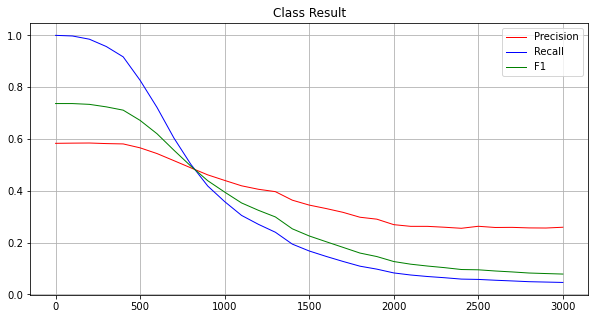

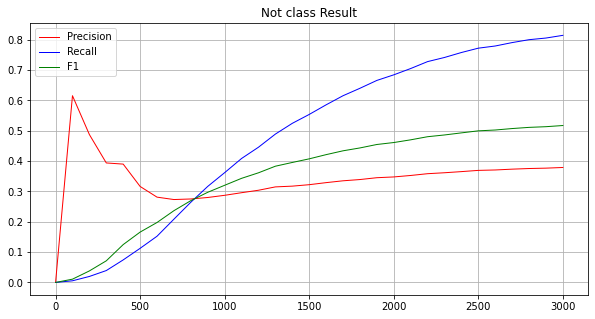

In [22]:
plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

In [77]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv'
# TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'

test_docs = list(load_csv_multiprocess(TEST_DATA_FILE, calc_features))

23:09:21 INFO:Complete items 00000 in worker_id 0
23:09:21 INFO:Complete items 00000 in worker_id 1
23:09:21 INFO:Complete items 00000 in worker_id 2
23:09:21 INFO:Complete items 00000 in worker_id 3
23:09:49 INFO:Complete items 01000 in worker_id 2
23:09:52 INFO:Complete items 01000 in worker_id 1
23:10:04 INFO:Complete items 01000 in worker_id 3
23:10:20 INFO:Complete items 02000 in worker_id 1
23:10:21 INFO:Complete items 02000 in worker_id 2
23:10:58 INFO:Complete items 03000 in worker_id 2
23:10:59 INFO:Complete items 03000 in worker_id 1
23:11:27 INFO:Complete items 04000 in worker_id 2
23:11:30 INFO:Complete items 04000 in worker_id 1
23:11:56 INFO:Complete items 05000 in worker_id 2
23:12:08 INFO:Complete items 05000 in worker_id 1
23:12:21 INFO:Complete items 06000 in worker_id 2
23:12:32 INFO:Complete items 01000 in worker_id 0
23:12:45 INFO:Complete items 07000 in worker_id 2
23:12:59 INFO:Complete items 02000 in worker_id 0
23:13:04 INFO:Complete items 08000 in worker_id 2


In [61]:
for doc in list(train_docs):
    html_texts.append(doc.features[10])

In [62]:
v1 = TfidfVectorizer(max_features=200).fit(html_texts)

In [79]:
%%time


X = []
y = []
ids = []
for doc in test_docs:
    X.append(doc.features)
    ids.append(doc.doc_id)
print(np.array(X).shape)
y = clf.predict(X)
threshold = 800

with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
#     for item in classifier.predict_all(test_docs):
#         prediction =  1 if item[3] > threshold else 0
#         writer.writerow([item[0], prediction])
    i = 0
    for doc in test_docs:
        writer.writerow([doc.doc_id, y[i]])
        i += 1

(16039, 210)
CPU times: user 1.8 s, sys: 6.09 ms, total: 1.81 s
Wall time: 1.82 s


In [114]:
y.sum()

8342

In [115]:
with open('my_submission.csv' , 'wt') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
#     for item in classifier.predict_all(test_docs):
#         prediction =  1 if item[3] > threshold else 0
#         writer.writerow([item[0], prediction])
    i = 0
    for id1 in ids:
        writer.writerow([id1, int(y[i])])
        i += 1